In [354]:
import aiohttp, json, pandas, geopandas
import matplotlib.pyplot as plt
import glymur
import numpy
from os import environ
import descartes
from io import BytesIO
from fastkml import kml
from glob import glob
from fastkml import kml
import asyncio
import aiobotocore


In [9]:
%matplotlib inline

In [10]:
COLORS = ["#EDE7D8", "#80726F", "#F2F2F2", "#84B1C6",    "#86B59F", "#666666", "#000000"]

In [11]:
turkey_borders = "https://raw.githubusercontent.com/cihadturhan/tr-geojson/master/geo/tr-cities-utf8.json"
base_url = "https://raw.githubusercontent.com/mgurdal/marble-growth/master/marble_deposit_locations"
deposits = [{
        "name": "Beige",
        "url": F"{base_url}/beige_marble.geojson",
    },
    {
        "name": "White",
        "url": F"{base_url}/white_marble.geojson",
    },
    {
        "name": "Colored",
        "url": F"{base_url}/colored_marble.geojson",
    },
    {
        "name": "Black",
        "url": F"{base_url}/black_marble.geojson",
    },
    {
        "name": "Travertine",
        "url": F"{base_url}/travertine_marble.geojson",
    },
    {
        "name": "Onyx",
        "url": F"{base_url}/onyx_marble.geojson",
    }]

In [355]:
AWS_ACCESS_KEY_ID = environ["AWS_ACCESS_KEY_ID"]
AWS_SECRET_ACCESS_KEY = environ["AWS_SECRET_ACCESS_KEY"]

session = aiobotocore.get_session()


In [12]:
async with aiohttp.ClientSession() as better_than_requests:

    gdf = None
    dataset = {"type": "FeatureCollection", "features": []}
    for deposit in deposits:
        resp = await better_than_requests.get(deposit["url"])
        if resp.status != 200:
            print(resp.reason)
        features = json.loads(await resp.text(), encoding="ISO-8859-15")

        dataset["features"] += [
            {
                **feature,
                "properties": {
                    **feature["properties"],
                    "type": deposit["name"]
                }
            } for feature in features["features"]
        ]

    gdf = geopandas.GeoDataFrame.from_features(dataset)
    gdf.rename(columns={"name": "owner"}, inplace=True)

    resp = await better_than_requests.get(turkey_borders)
    turkey_geojson = json.loads(await resp.text())
    turkey = geopandas.GeoDataFrame.from_features(turkey_geojson)

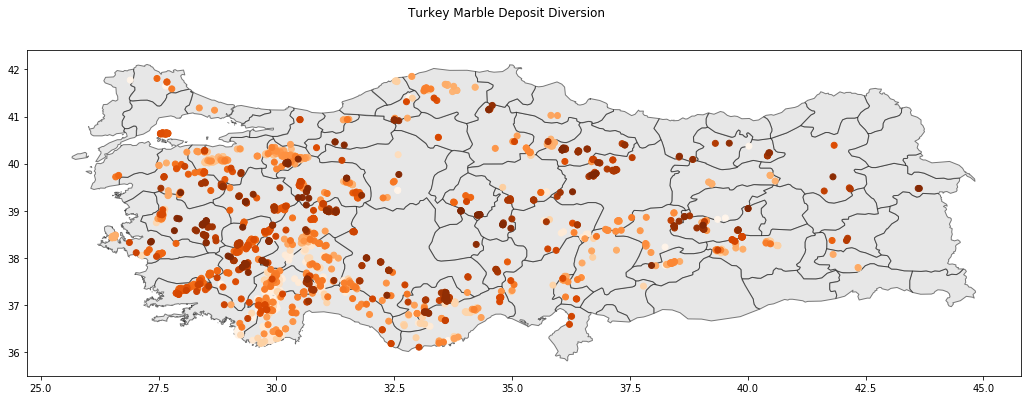

In [13]:
ax = turkey.plot(color="#D1D1D1", figsize=(19, 6), alpha=0.5, edgecolor='k')
plt.suptitle('Turkey Marble Deposit Diversion')
gdf.plot(cmap="Oranges", ax=ax)


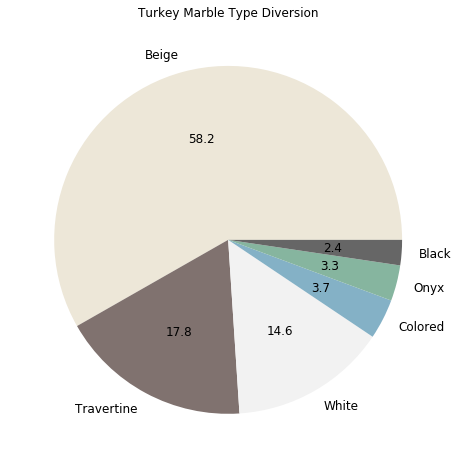

In [14]:
_ = gdf["type"].value_counts().plot.pie(
    autopct="%.1f",
    colors=COLORS,
    figsize=(8, 8),
    labels=gdf["type"].value_counts().index,
    fontsize=12,
    title="Turkey Marble Type Diversion",
    x=None
)
x_axis = _.yaxis.set_label_text('')

In [19]:
async def search(session, key):
    async with session.create_client('s3', region_name='eu-central-1') as client:
        # upload object to amazon s3
        pr = await client.list_objects(Bucket='sentinel-s2-l2a', Prefix=key, MaxKeys=2147483647,  RequestPayer='requester')
    return pr

async def download(session, key):
    
    async with session.create_client('s3', region_name='eu-central-1') as client:

        response = await client.get_object(Bucket='sentinel-s2-l2a',
                                    Key=key, 
                                    RequestPayer='requester')
        response_content = await response['Body'].read()
        fname = key.replace("/", "_")
        with open(fname, 'wb') as file:
            file.write(response_content)
        return fname



In [20]:
pr = await search(session, "tiles/1/C/CV/2018/12/13/0/")
len(pr["Contents"])

117

In [21]:
fname = await download(session, pr["Contents"][3]["Key"])

In [22]:
jp2 = glymur.Jp2k("tiles_1_C_CV_2018_12_13_0_R10m_B04.jp2")
fullres = jp2[:]

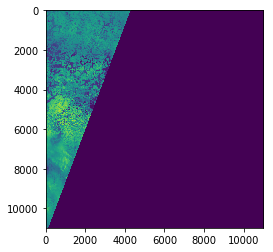

In [23]:
plt.imshow(fullres)

In [345]:
sentinel_gdf = geopandas.read_file("sentinel_map/sentinel_tiles.geojson")

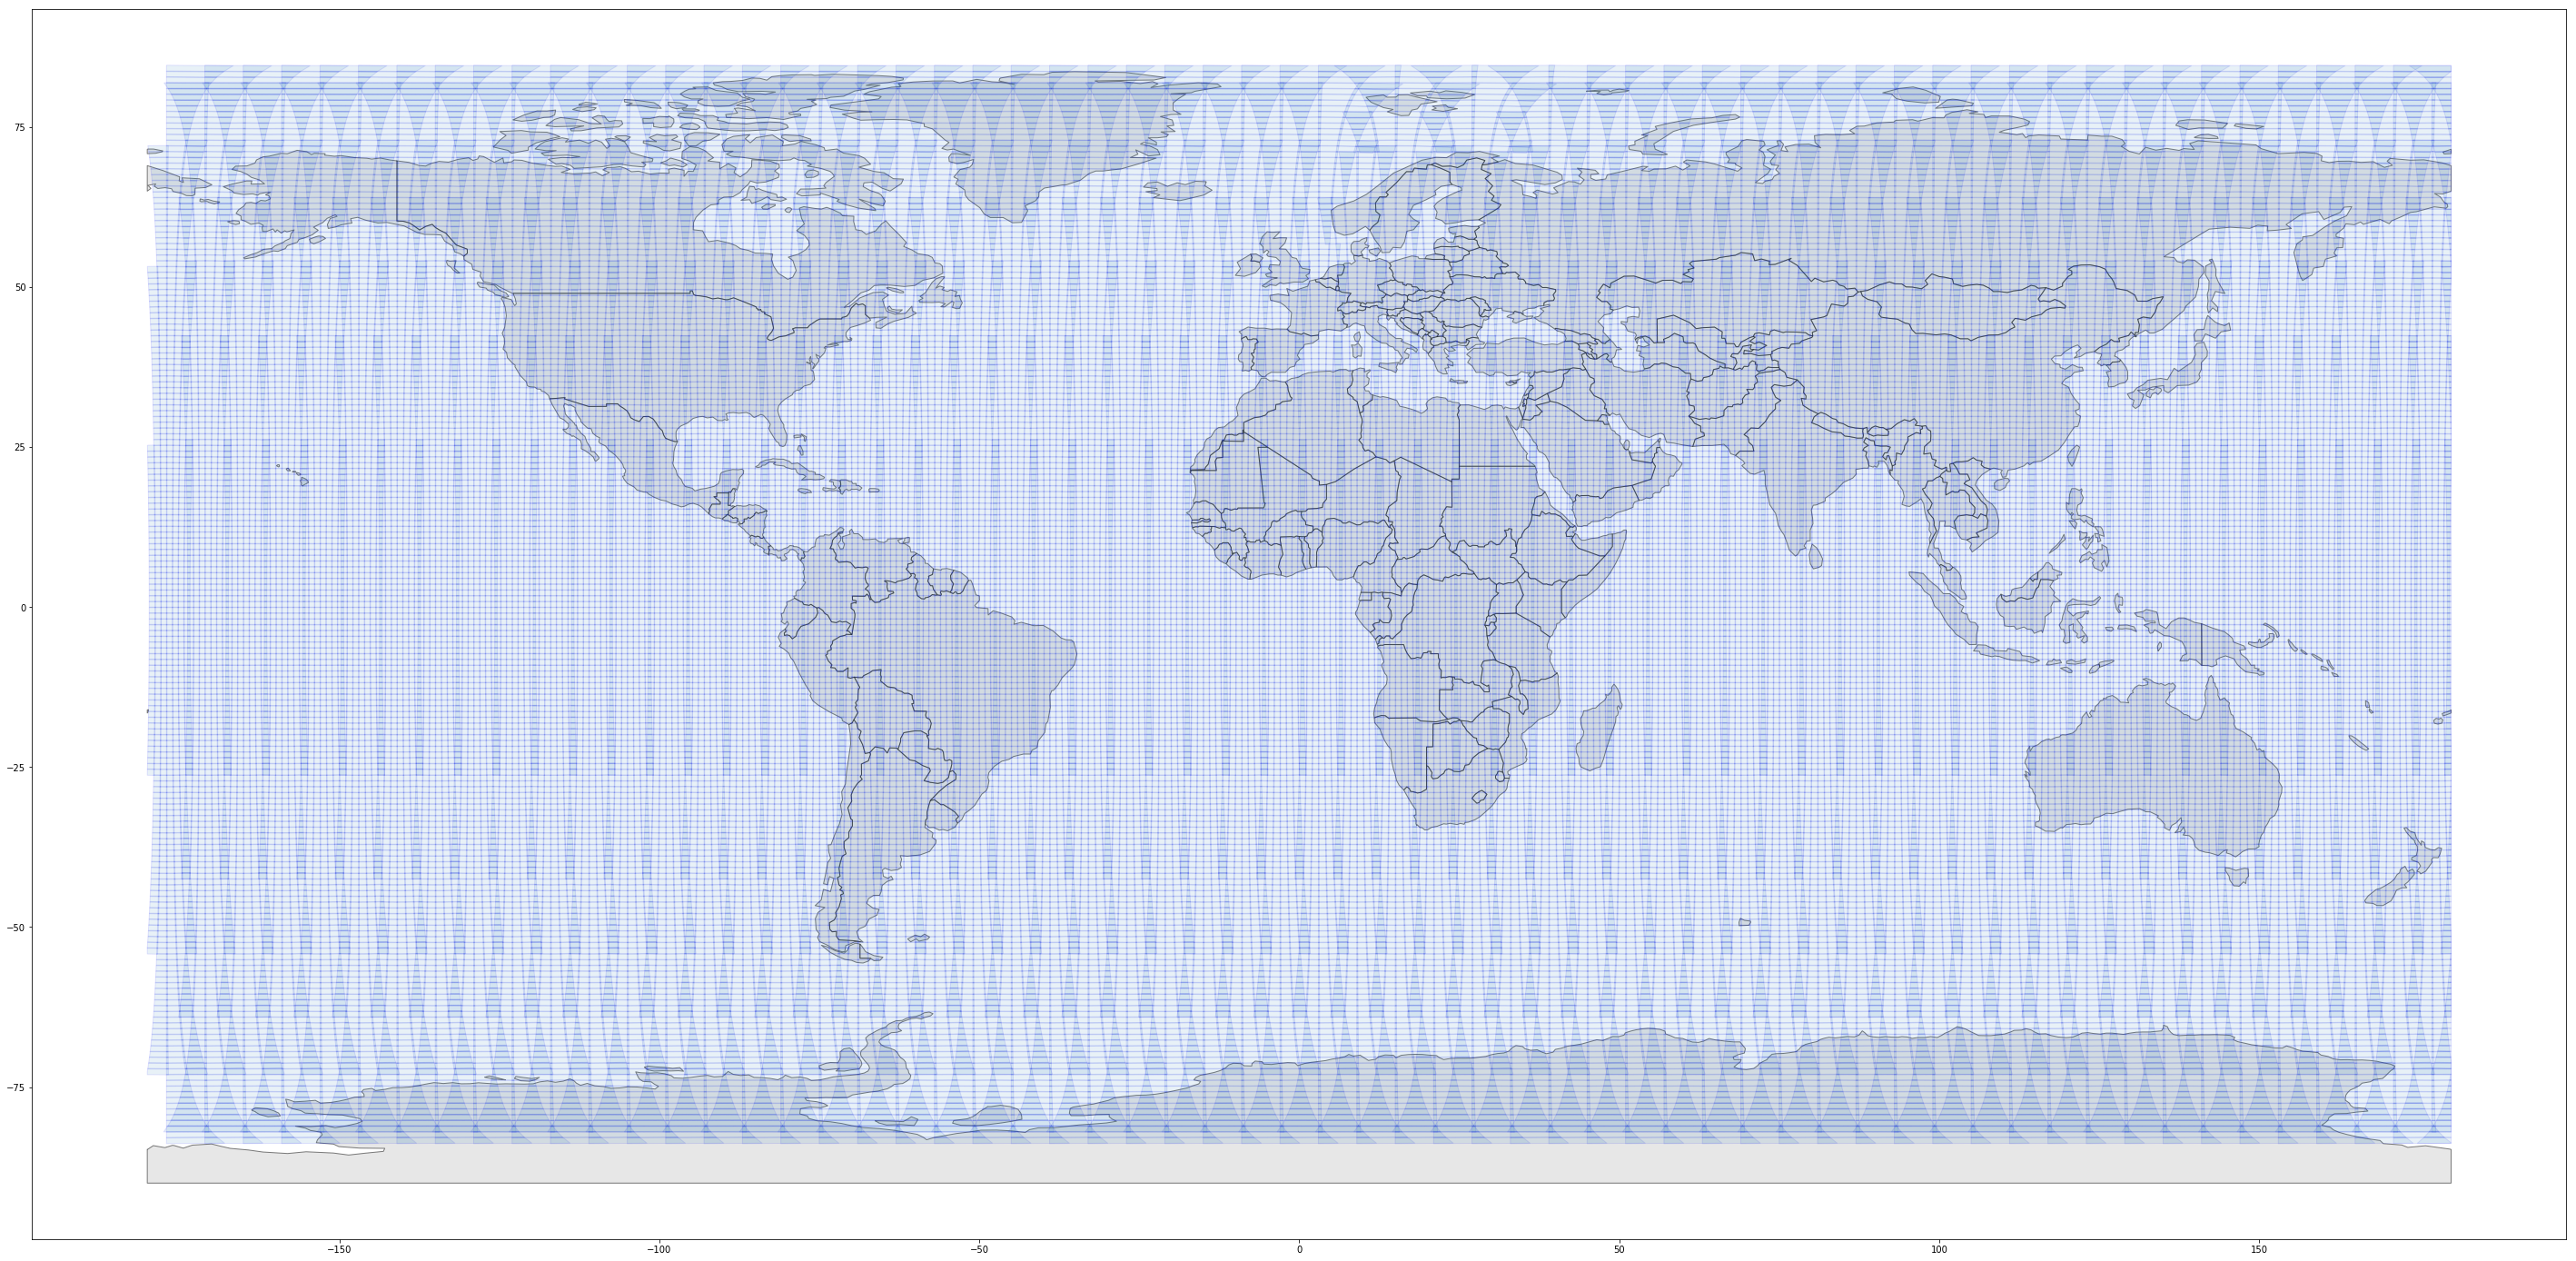

In [346]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color="#D1D1D1", figsize=(50, 50), alpha=0.5, edgecolor='k')
sentinel_gdf.geometry.apply(lambda g: g[0]).plot(ax=ax, alpha=0.1, edgecolor='b')

In [350]:
mugla = turkey.loc[turkey.name == "Muğla"]
mugla_geom = mugla.geometry.values[0]
mugla_tile = sentinel_gdf.geometry[sentinel_gdf.geometry.intersects(mugla_geom)]

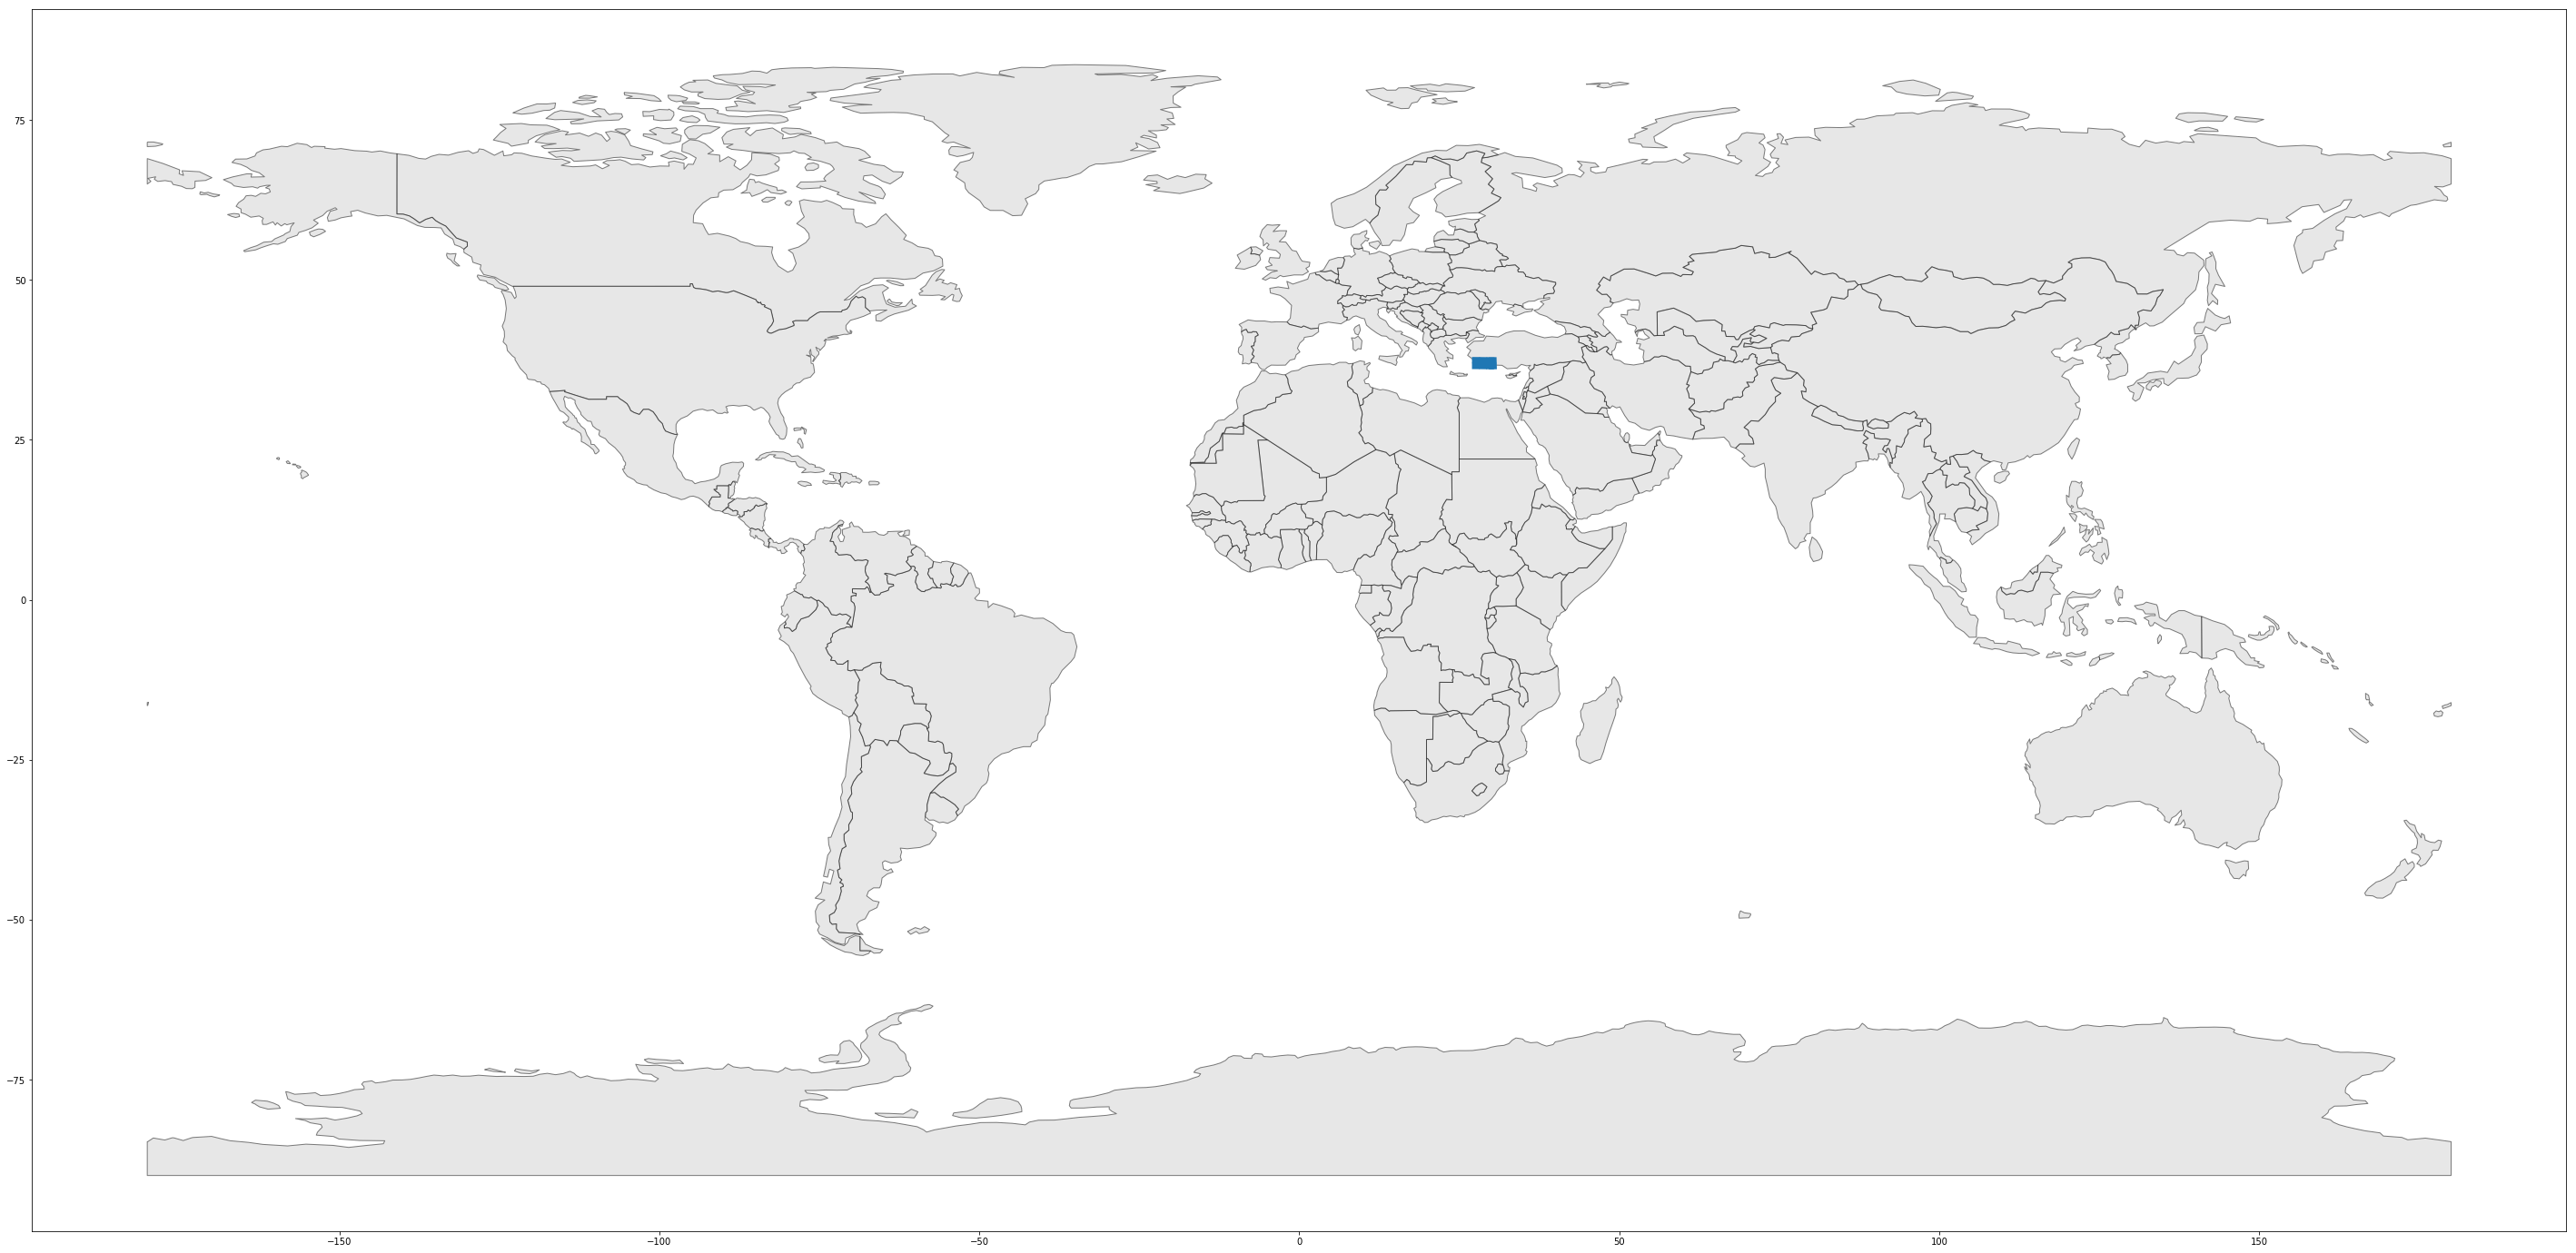

In [353]:
ax = world.plot(color="#D1D1D1", figsize=(50, 50), alpha=0.5, edgecolor='k')
mugla_tile.apply(lambda g: g[0]).plot(ax=ax)